In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import plotly.offline
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [2]:
# importing train data to learn
train = pd.read_csv(r"C:\Users\Gabriel\PythonProjects\Untitled Folder\train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv(r"C:\Users\Gabriel\PythonProjects\Untitled Folder\store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [3]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


### This is a panel dataset that contains sales, customer traffic, promotion and other information for each store throughout the period of January 2013 to July 2015. "Open" denotes whether the particular store is open on the observed date or not, and "Promo" denotes whether the store has promotion on that observed date.

In [4]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### On average, throughout the sampling period, each customer spent 9.49 dollars in the observed store. The maximum amount that a customer has spent in one of the stores during the observation period is 64.96 dollars.

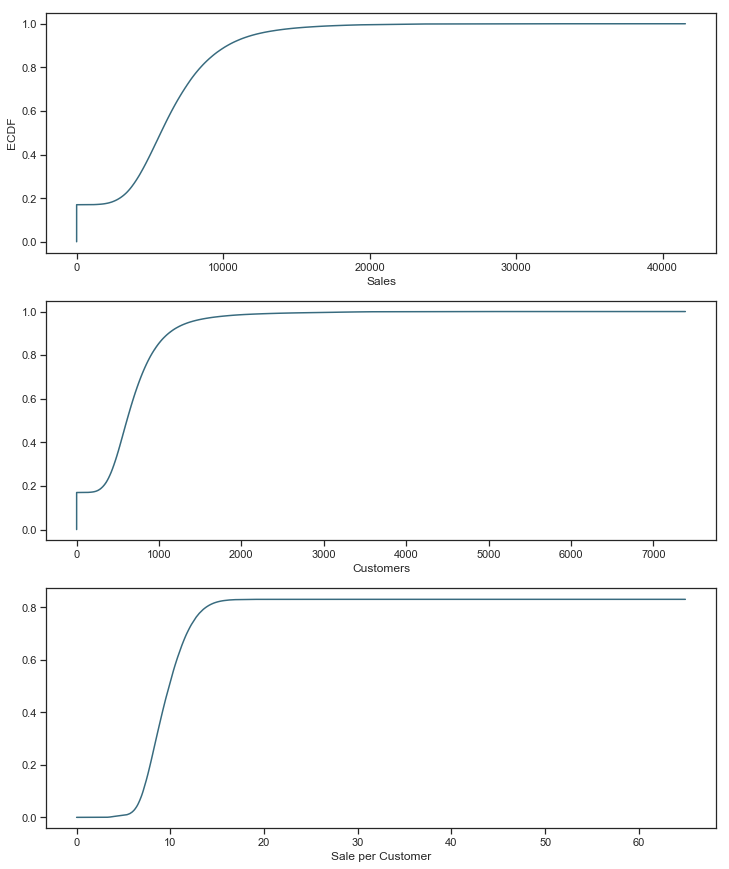

In [5]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 15))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

### The above graphs show culmulative sales, customers that visited each stores, and sales per customer during the sampling period. 18-20% stores have zero sales and customers. This may be a result of closed stores. However it does render further investigation if that's not the case. In addition, the cumulative distribution has long tail, for example only 2% of the stores have sales over 15K. What is it that contributes to the high sales and customer traffic? Is it holiday? Promotion?     

In [6]:
def sales_dist(data):
    sales_df = data.copy(deep=True)
    sales_df['Qty_bins'] = pd.cut(sales_df['Sales'], [0,5000,10000,15000,20000,25000,30000,35000,40000,45000])
    print('Max sale:', sales_df['Sales'].max())
    print('Min sale:', sales_df['Sales'].min())
    print('Avg sale:', sales_df['Sales'].mean())
    print()
    return sales_df

sales_df = sales_dist(train)

total_points = pd.value_counts(sales_df.Qty_bins).sum()
print('Sales bucket v/s Count of Store:')
display(pd.value_counts(sales_df['Qty_bins']))
display(pd.value_counts(sales_df['Qty_bins']).apply(lambda s: (s/total_points)*100))

Max sale: 41551
Min sale: 0
Avg sale: 5773.818972305593

Sales bucket v/s Count of Store:


(5000, 10000]     500465
(0, 5000]         230240
(10000, 15000]     93902
(15000, 20000]     15632
(20000, 25000]      3341
(25000, 30000]       605
(30000, 35000]       135
(35000, 40000]        17
(40000, 45000]         1
Name: Qty_bins, dtype: int64

(5000, 10000]     59.273064
(0, 5000]         27.268700
(10000, 15000]    11.121376
(15000, 20000]     1.851391
(20000, 25000]     0.395695
(25000, 30000]     0.071654
(30000, 35000]     0.015989
(35000, 40000]     0.002013
(40000, 45000]     0.000118
Name: Qty_bins, dtype: float64

In [7]:
def sales_dist(data):
    sales_df = data.copy(deep=True)
    sales_df['Qty_bins'] = pd.cut(sales_df['Customers'], [0,250,500,750,1000,1250,1500,2000,8000])
    print('Max Customer:', sales_df['Customers'].max())
    print('Min Customer:', sales_df['Customers'].min())
    print('Avg Customer:', sales_df['Customers'].mean())
    print()
    return sales_df

sales_df = sales_dist(train)

total_points = pd.value_counts(sales_df.Qty_bins).sum()
print('Customer bucket v/s Count of Customers:')
display(pd.value_counts(sales_df['Qty_bins']))
display(pd.value_counts(sales_df['Qty_bins']).apply(lambda s: (s/total_points)*100))

Max Customer: 7388
Min Customer: 0
Avg Customer: 633.1459464082602

Customer bucket v/s Count of Customers:


(500, 750]      322247
(750, 1000]     188611
(250, 500]      177803
(1000, 1250]     79001
(1250, 1500]     31399
(1500, 2000]     22145
(2000, 8000]     14732
(0, 250]          8402
Name: Qty_bins, dtype: int64

(500, 750]      38.165549
(750, 1000]     22.338276
(250, 500]      21.058223
(1000, 1250]     9.356539
(1250, 1500]     3.718763
(1500, 2000]     2.622759
(2000, 8000]     1.744795
(0, 250]         0.995097
Name: Qty_bins, dtype: float64

## Clean Data and parepare forecasting

In [8]:
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


### In the aforementioned 18-20% of stores with zero sales and customer traffic, 17% is explained by store closure. Therefore I will drop these data for the forecasting purpose to increase the forecast accuracy.


In [9]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head()

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


### Throughout the sampling period, there are 54 days during which opened stores has no sales on working days. No reason is documented in this dataset.

In [10]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

In total:  (844338, 13)


In [11]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### The second set of data contains information on store type, competition distance, when did the competition start, whether the store has promotion (denoted by Promo2), how long the stores has been promoting, how frequently does each store promote.

## There are missing data issues that will be fixed for the forecasting purpose.

In [12]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
store[pd.isnull(store.CompetitionDistance)]
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape
store.fillna(0, inplace = True)

### The above mentioned two datasets are combined to conduct further analysis.

In [14]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [15]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


### There are 4 different store types, and the "count" column describes the number of observations for each store type. Mean stands for the average sales for each store type.

In [16]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


### The above table provides another view of the sales by store type. As one can see, store type A has the most customer traffic and the makes the largest amount of sales out of the 4 different store types.

## Seasonality Analysis

C:\Users\Gabriel\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



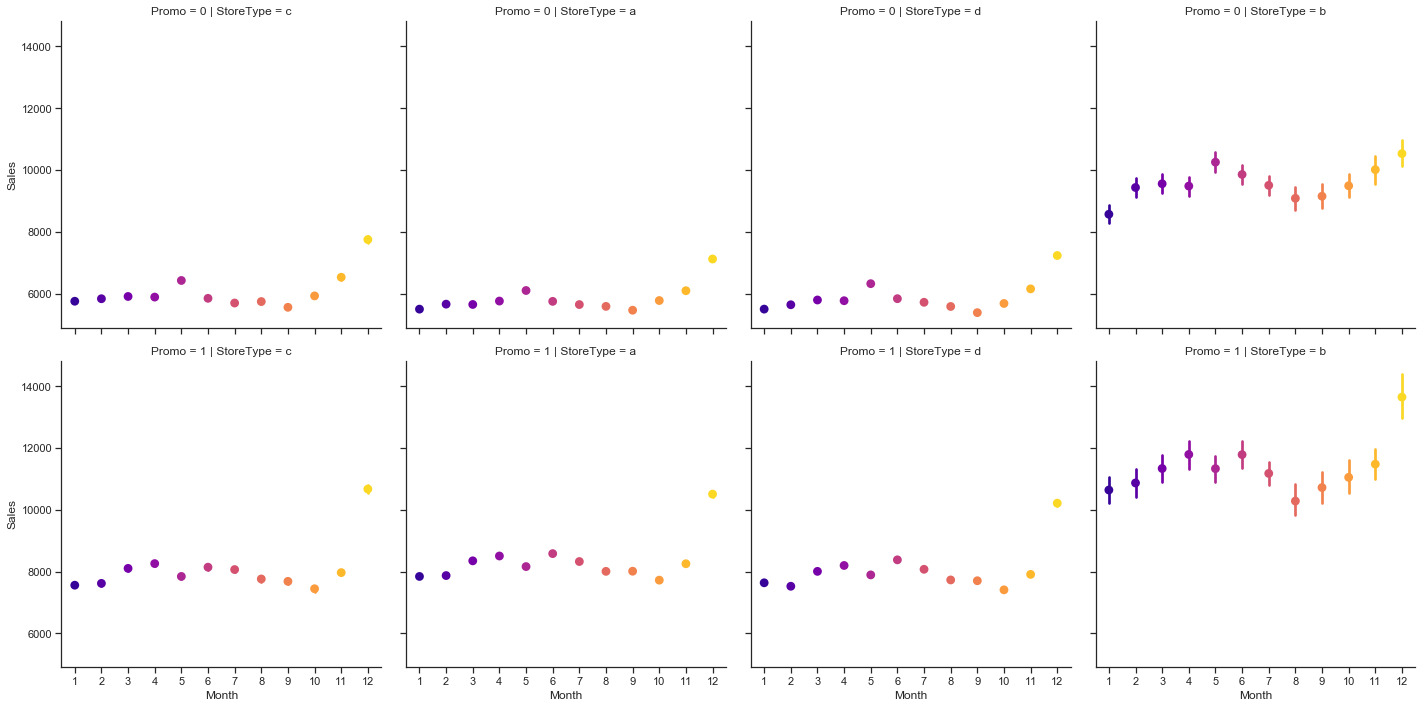

In [17]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               #hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               ) 

### All store types exhibit similar seasonal trend in sales, with December having the highest sales throughout the 12-month period. In general, stores with promotion have higher sales level than stores that do not.

C:\Users\Gabriel\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



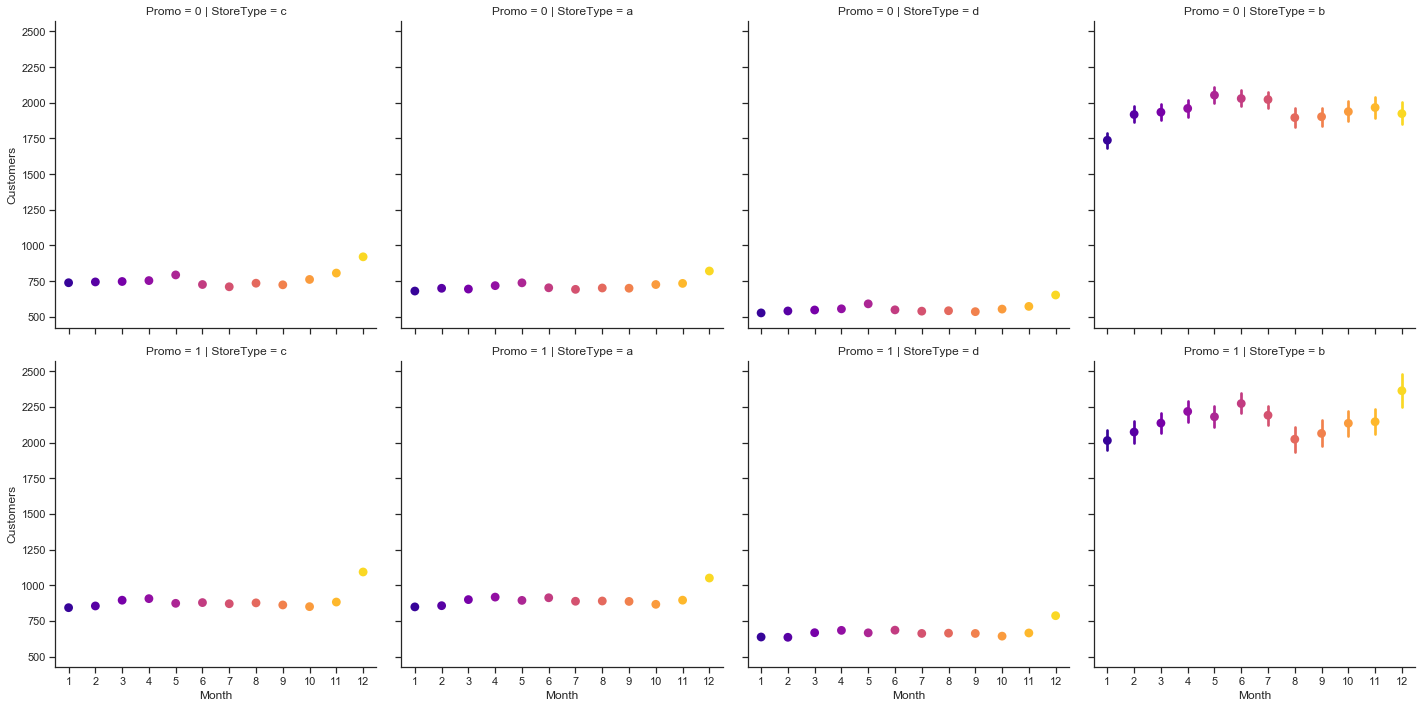

In [18]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               #hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

### All store types exhibit similar seasonal trend in customer traffic as well, with December having the highest customer traffic. When looking within the same store types, stores with promotion in general have higher sales level than stores that do not.

C:\Users\Gabriel\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



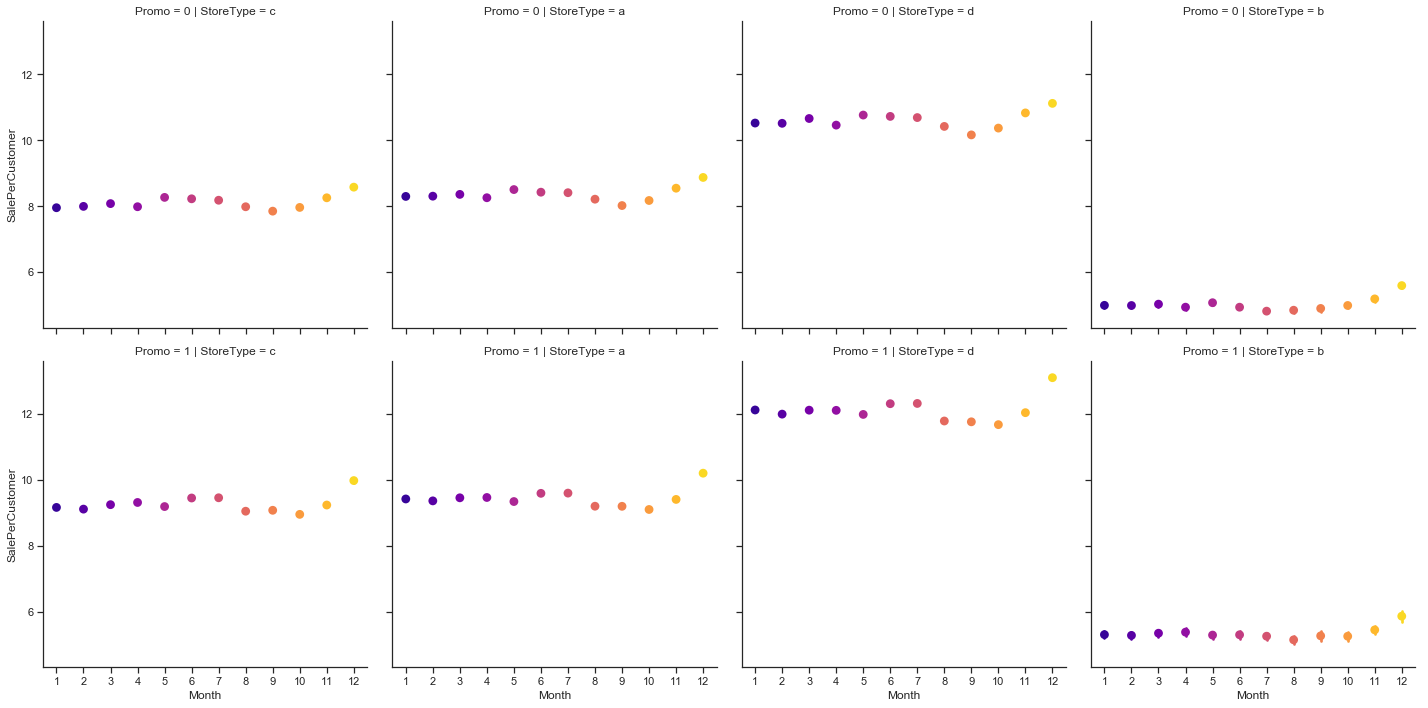

In [99]:
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               #hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

### Seasonal trend is consistent throughout all store types. However, store type B here exhibits the lowest sales per customer, even though it has the highest total sales.

C:\Users\Gabriel\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



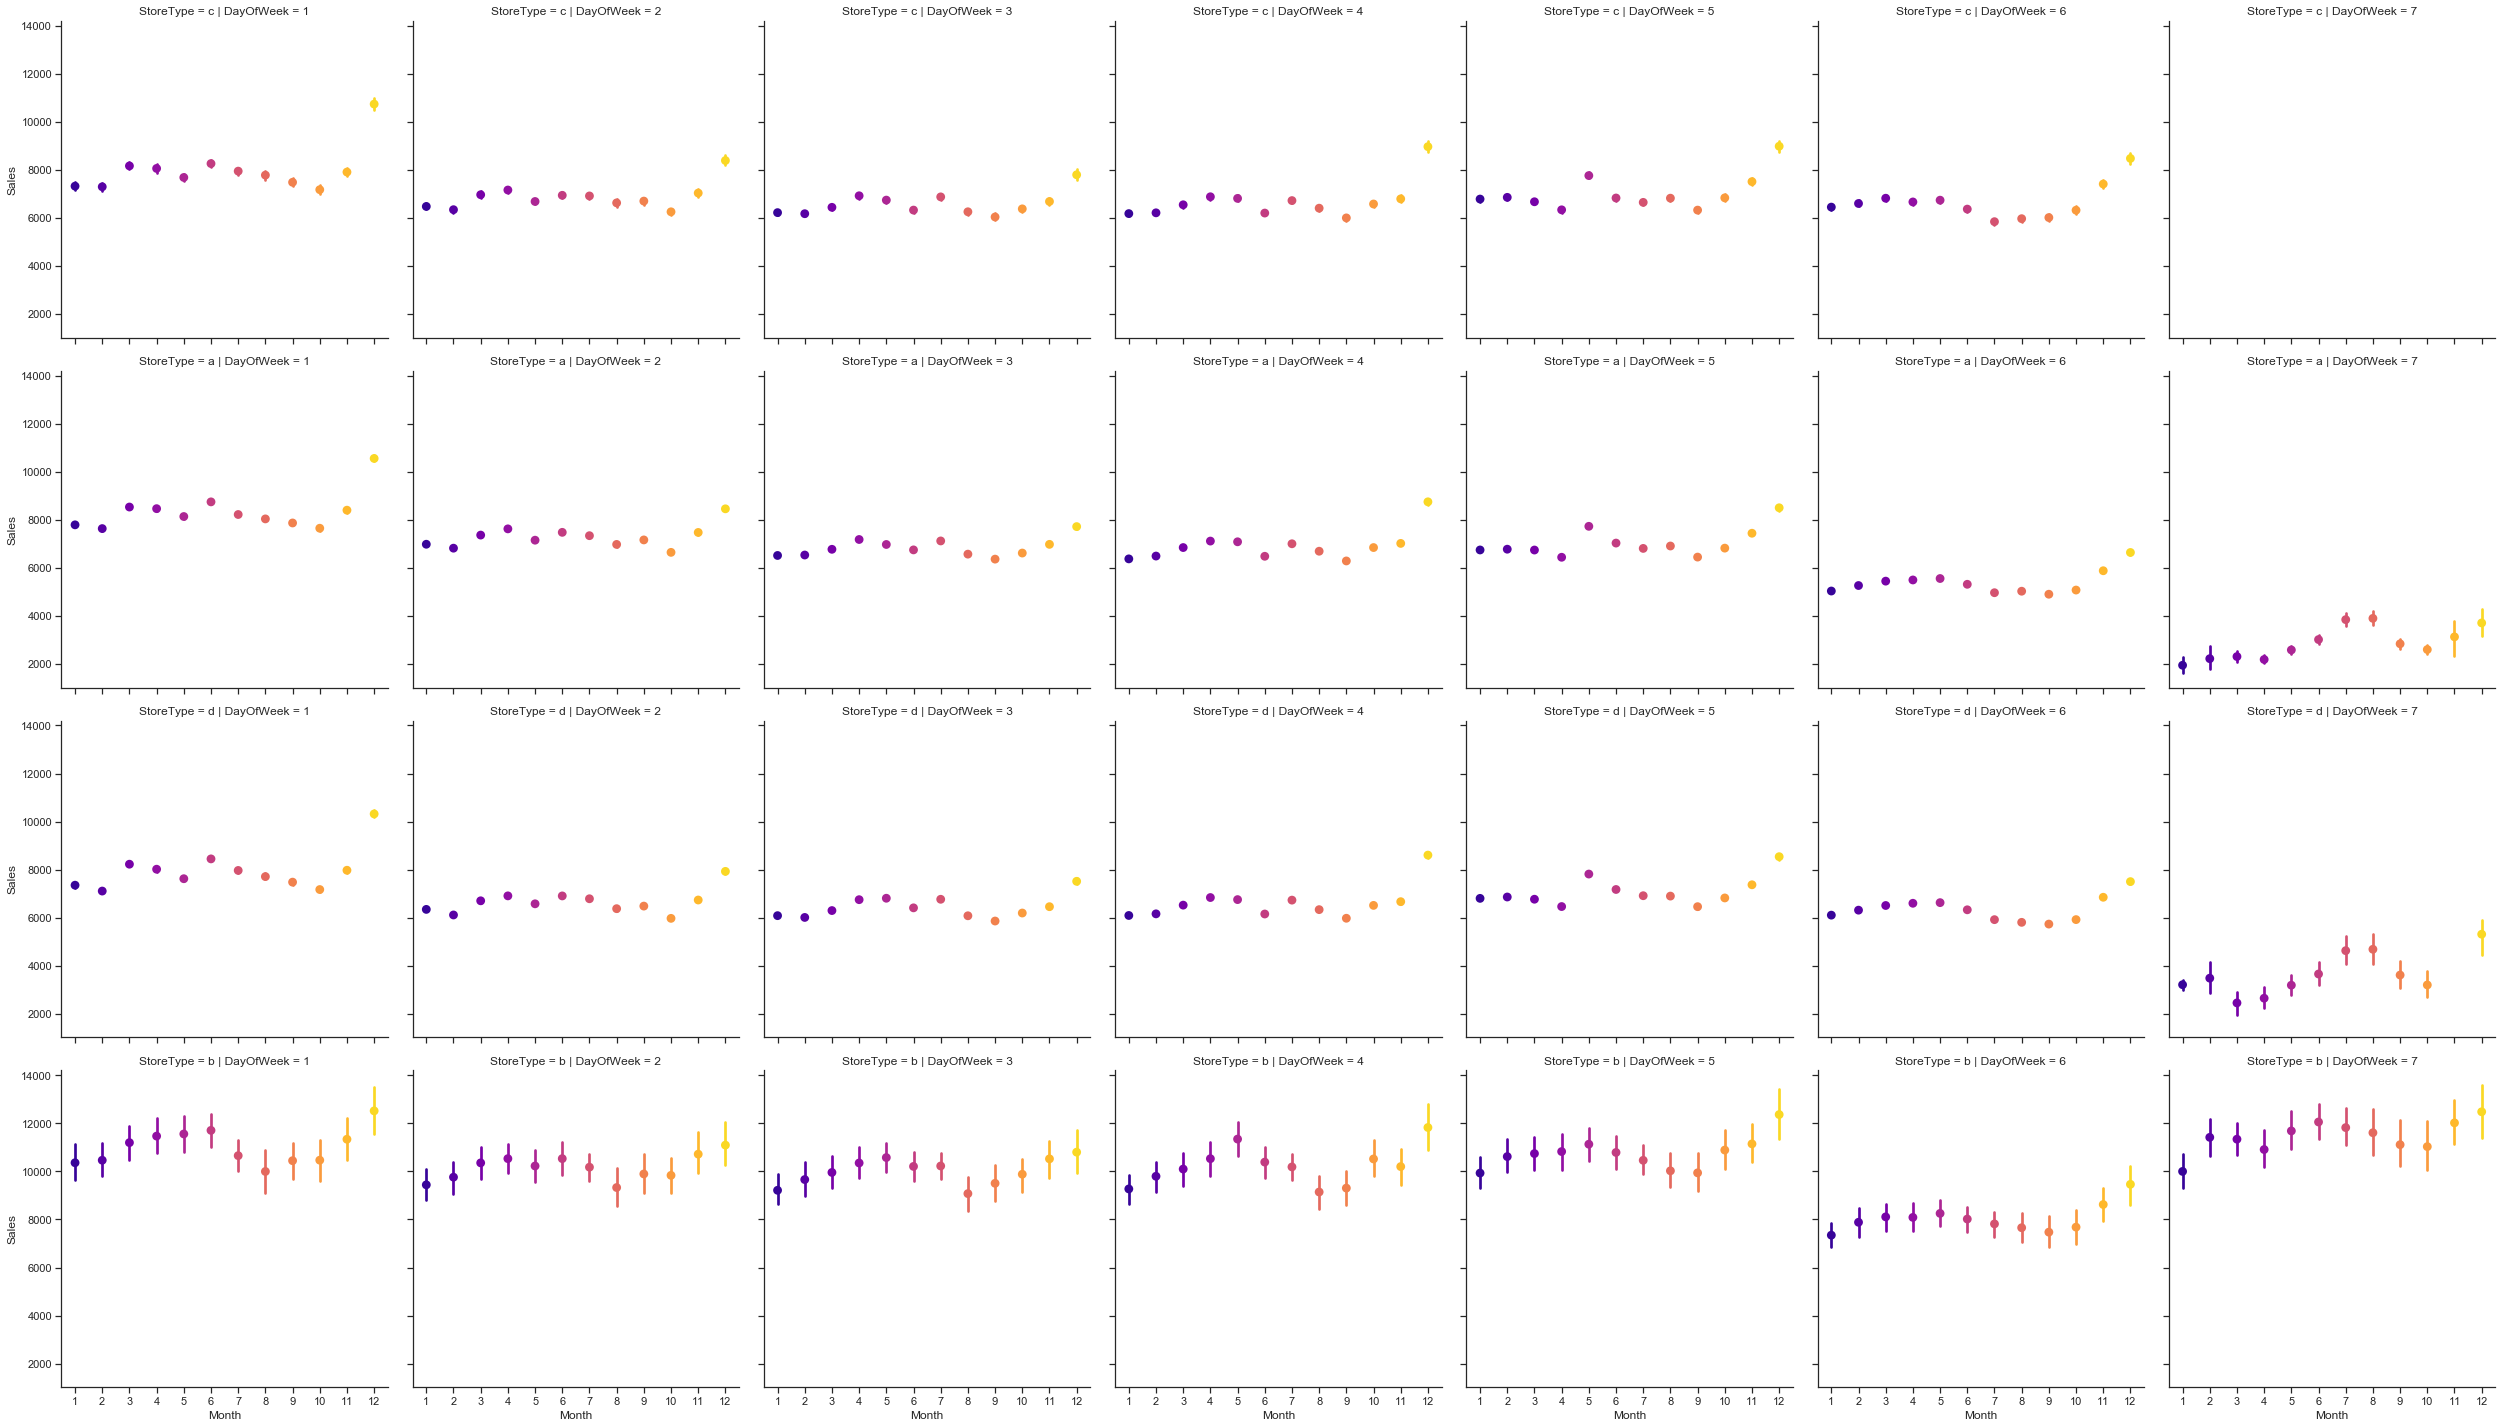

In [20]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               #hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

### The above graph shows the average daily sales from Monday to Sunday for each store type throughout the 12 months period. Saturday sales are low throughout the week for all the store types. While store type b enjoys the highest sales on Sundays, other store types see the lowest sales on Sunday.

In [21]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

In [22]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


### Store type b, while enjoying the highest sales, also has the most competition among all four store types.

## Correlational Analysis
### Sales has strong posititive correlation with the amount of customer, promotion 1, and sales per customer, which is consistent with my expectation. However, contrary to my expectation, promo2, promo2 start day, and competition do not exhibit strong correlation with sales.

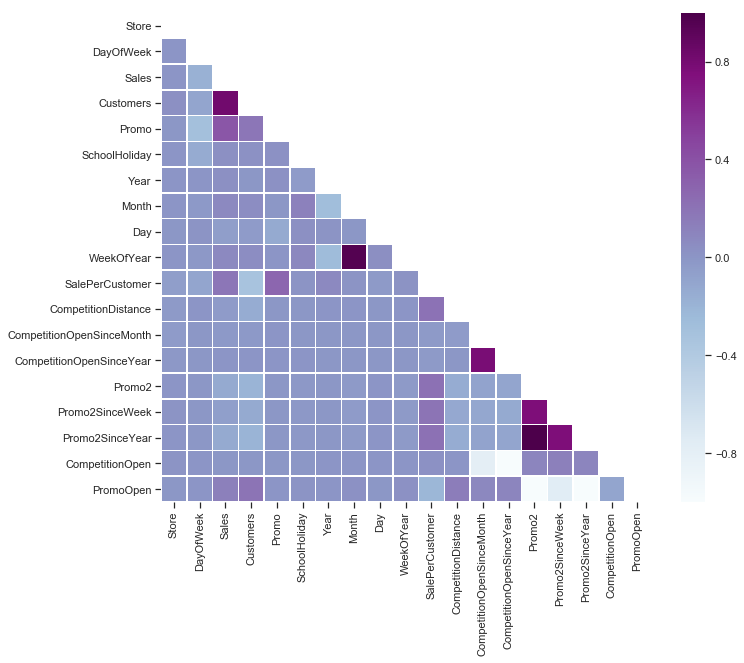

In [23]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

C:\Users\Gabriel\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



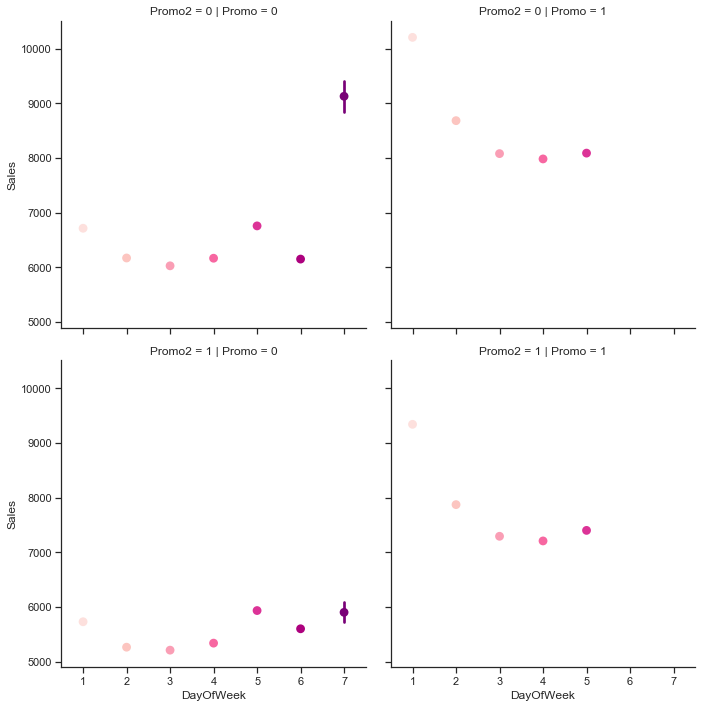

In [31]:
#sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               #hue = 'Promo2',
               palette = 'RdPu');

### High Sunday sales is observed throughout the stores without any promotion. With only Promo, Monday sales increase for about 76%. Promo2 seems to be negatively affecting the sales, as shown by the bottom two graphs.

## Time-Series Analysis per Store Type

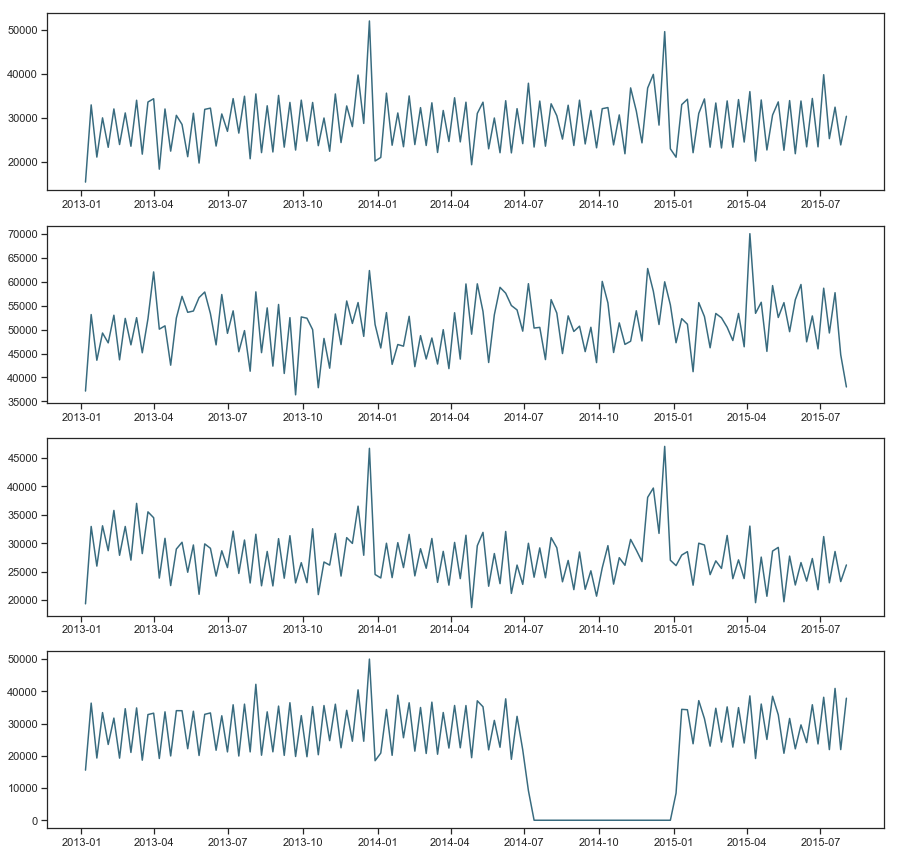

In [68]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15, 15))

# store types
sales_a1 = sales_a.resample('W').sum()
sales_b1 = sales_b.resample('W').sum()
sales_c1 = sales_c.resample('W').sum()
sales_d1 = sales_d.resample('W').sum()

ax1.plot(sales_a1.index,sales_a1.values, color=c)
ax2.plot(sales_b1.index,sales_b1.values, color=c)
ax3.plot(sales_c1.index,sales_c1.values, color=c)
ax4.plot(sales_d1.index,sales_d1.values, color=c)

### Weekly sales pattern for each type of stores. There is no data for type d because stores were closed between July 2014 and Januray 2015.
### Store a and c types have similar seasonality and b and d have their own pattern.

## Yearly Trend 

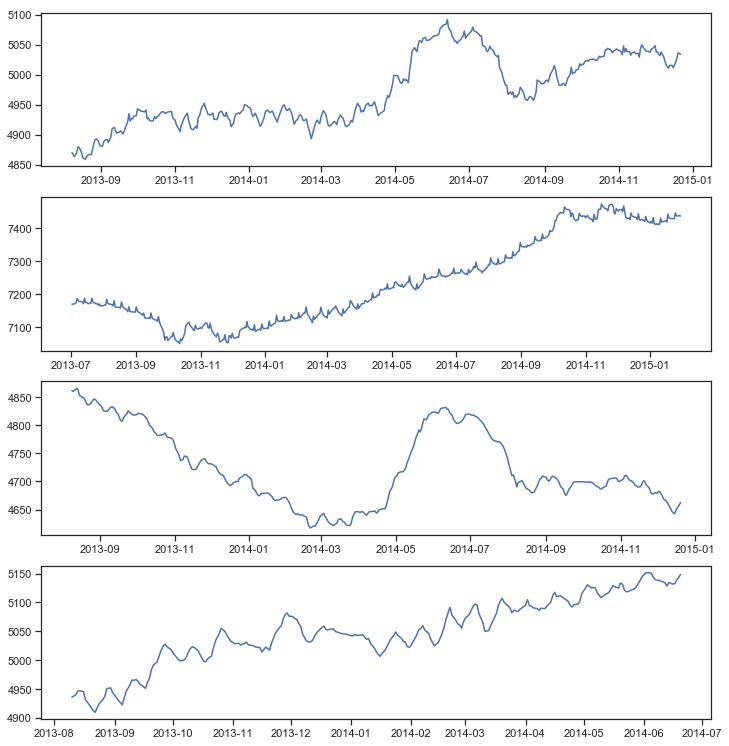

In [80]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
a = decomposition_a.trend
ax1.plot(a.index,a.values)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
b = decomposition_b.trend
ax2.plot(b.index,b.values)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
c = decomposition_c.trend
ax3.plot(c.index,c.values)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
d = decomposition_d.trend
ax4.plot(d.index,d.values)


## Sales for store type a, b,and d experienced upward trend throughout the sampling period, whereas sales for store type c decreased. Store type a experienced the smallest increase in sales during the period.

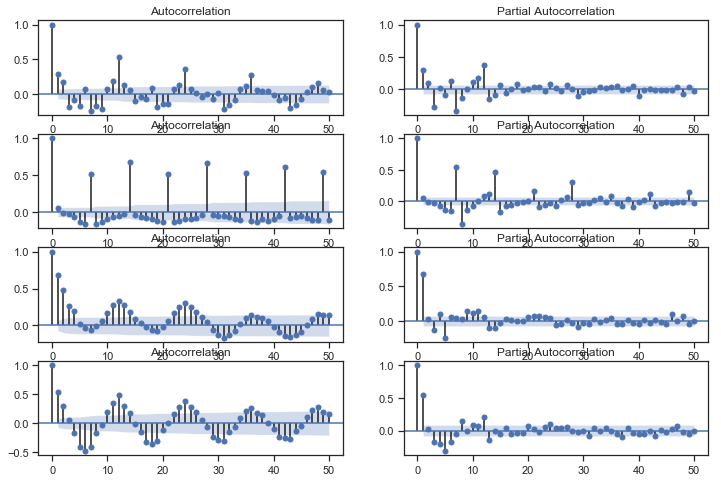

In [86]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca())
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca())

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca())
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca())

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca())
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca())

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca())
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca())

plt.show()

### Each horizontal pair is for one 'store type' from A to D. 
#Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.
These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

In [88]:
# importing data
df = pd.read_csv(r"C:\Users\Gabriel\PythonProjects\Untitled Folder\train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [89]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


### Daily Sales Plot for Sampling Period

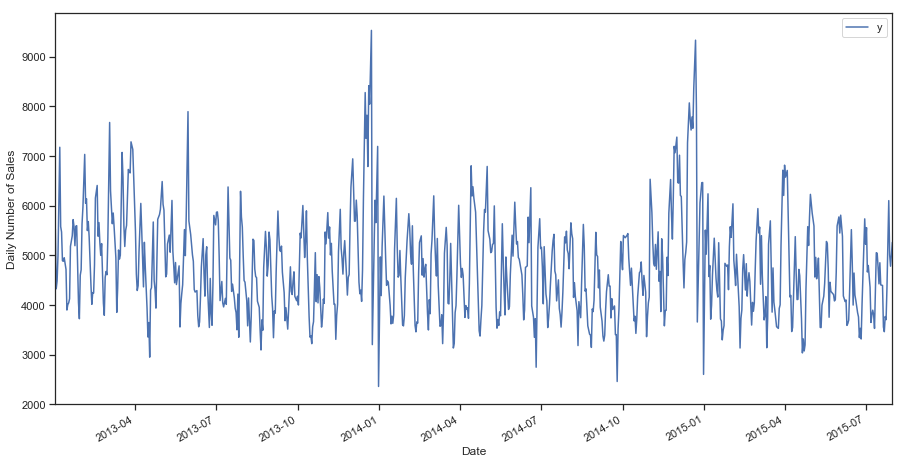

In [92]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (15, 8))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Holiday and promotion data are added to train the machine learning

In [93]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [94]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [95]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.196373,2446.709726,5574.497424
817,2015-09-06,4086.982771,2553.815099,5594.581717
818,2015-09-07,4161.672877,2542.187034,5856.741599
819,2015-09-08,3664.111439,2090.893057,5199.077604
820,2015-09-09,3550.936324,1920.901248,5129.605653
821,2015-09-10,3462.430053,1847.972060,5182.171090
822,2015-09-11,3717.080395,2113.500009,5241.047892


## Forecast store 1

In [96]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

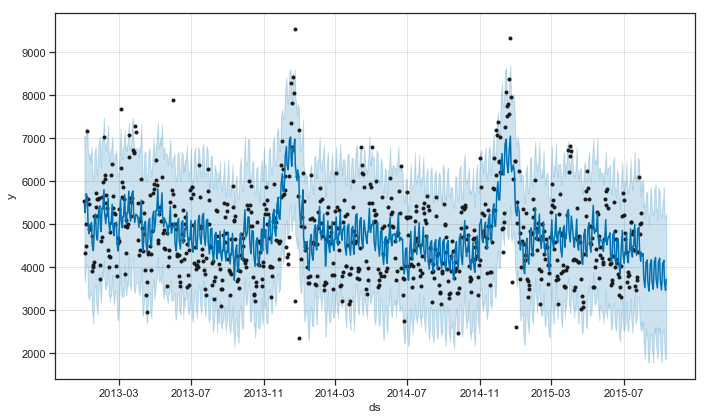

In [97]:
# visualizing predicions
my_model.plot(forecast);

### Prophet plots the observed values of our time series (the black dots, actual values that are in the dataset during the sampling period), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions). There are roughly 16 values that are outside of the uncertainty intervals.
### As we see Prophet catches the trends and most of the time gets future values right. One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manually included holidays contribute to the overall forecasted values.


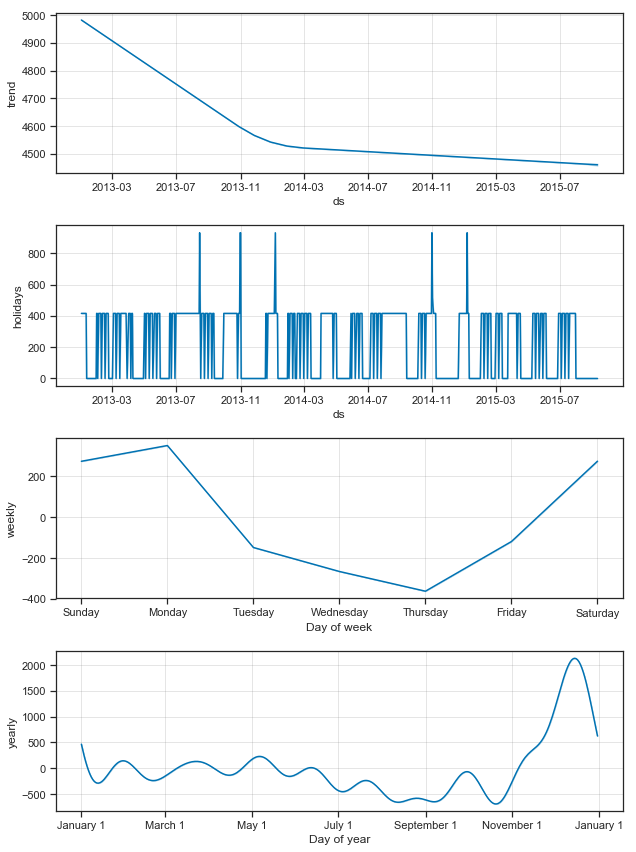

In [98]:
my_model.plot_components(forecast);

### The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiday gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the busiest season occurs during the Christmas holidays.